# Работа с Web-scraping

### Сохранение полноформатных изображений

In [2]:
import os
import time
import requests
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from tqdm import tqdm
from selenium.webdriver.chrome.service import Service
from webdriver_manager.chrome import ChromeDriverManager
import shutil
import random
import matplotlib.pyplot as plt
import cv2

In [3]:
# Настройки
YANDEX_IMAGES_URL = "https://yandex.ru/images/"
SAVE_DIR_FULL = "dataset"
CATEGORIES = ["polar bear", "brown bear"]
IMAGES_PER_CATEGORY = 52

In [5]:
def create_folders():
    '''
        Создание дирректорий для датасета
        full_path: Полноразмерные изображения
    '''
    for category in CATEGORIES:
        full_path = os.path.join(SAVE_DIR_FULL, category.replace(" ", "_"))
        os.makedirs(full_path, exist_ok=True)

def init_driver():
    '''
        Инициализация драйвера
    '''
    options = webdriver.ChromeOptions()
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver



def is_jpg(url):
    """ Проверяет, является ли изображение JPG по HTTP-заголовку Content-Type """
    try:
        response = requests.head(url, timeout=3)
        content_type = response.headers.get("Content-Type", "")
        return "image/jpeg" in content_type
    except requests.RequestException:
        return False

def fetch_images(driver, query, max_images):
    '''
        Поиск полноразмерных изображений (только JPG)
    '''
    driver.get(YANDEX_IMAGES_URL)
    search_box = driver.find_element(By.NAME, "text")
    search_box.send_keys(query)
    search_box.send_keys(Keys.RETURN)
    time.sleep(3)

    full_image_urls = []
    thumbnails = driver.find_elements(By.CLASS_NAME, "ImagesContentImage-Image")
    thumbnails[0].click()  # Открываем полноразмерное изображение
    time.sleep(2)


    while len(full_image_urls) < max_images:
  
        # Ждем появления полноразмерного изображения
        full_image = WebDriverWait(driver, 5).until(
            EC.presence_of_element_located((By.CLASS_NAME, "MMImage-Origin"))
        )
        full_image_url = full_image.get_attribute("src")
       
        # Проверяем формат полноразмерного изображения
        if full_image_url and full_image_url.startswith("http") and is_jpg(full_image_url):
            full_image_urls.append(full_image_url)

        if len(full_image_urls) >= max_images:
            break
        full_image.click()  # Открываем полноразмерное изображение
        time.sleep(2)       

    return list(full_image_urls[:50])


def download_images(image_urls, category, save_dir):
    '''
        Загрузка изображений
    '''
    save_path = os.path.join(save_dir, category.replace(" ", "_"))
    for idx, url in tqdm(enumerate(image_urls), total=len(image_urls), desc=f"Downloading {category}"):
        file_path = os.path.join(save_path, f"{idx:04d}.jpg")
        try:
            response = requests.get(url, stream=True, timeout=5)
            if response.status_code == 200:
                with open(file_path, "wb") as file:
                    for chunk in response.iter_content(1024):
                        file.write(chunk)
        except Exception as e:
            print(f"Ошибка при загрузке {url}: {e}")


def zip_folder(folder_path, zip_name):
    '''
    Сжимает всю папку в ZIP-архив.
    '''
    zip_path = f"{zip_name}.zip"  # Имя архива
    shutil.make_archive(zip_name, 'zip', folder_path)  # Создание архива
    print(f"Архив создан: {zip_path}")


In [6]:

def main():
    '''
        Основная функция
    '''
    
    create_folders()
    driver = init_driver()

    for category in CATEGORIES:
        print(f"Поиск изображений для: {category}")

        full_images = fetch_images(driver, category, IMAGES_PER_CATEGORY)
        print(f"Найдено {len(full_images)} полноразмерных изображений.")

        print(f"Загружаем полноразмерные изображения для: {category}")
        download_images(full_images, category, SAVE_DIR_FULL)

        print(f"Загрузка {category} завершена!\n")

    driver.quit()
    folder_path = "dataset"  # Укажите путь к вашей папке
    zip_folder(folder_path, "dataset_backup") 



In [5]:
if __name__ == "__main__":
    main()

Поиск изображений для: polar bear
Найдено 50 полноразмерных изображений.
Загружаем полноразмерные изображения для: polar bear


Загрузка polar bear завершена!

Поиск изображений для: brown bear
Найдено 50 полноразмерных изображений.
Загружаем полноразмерные изображения для: brown bear


Загрузка brown bear завершена!

Архив создан: dataset_backup.zip


📂 Папка: brown_bear


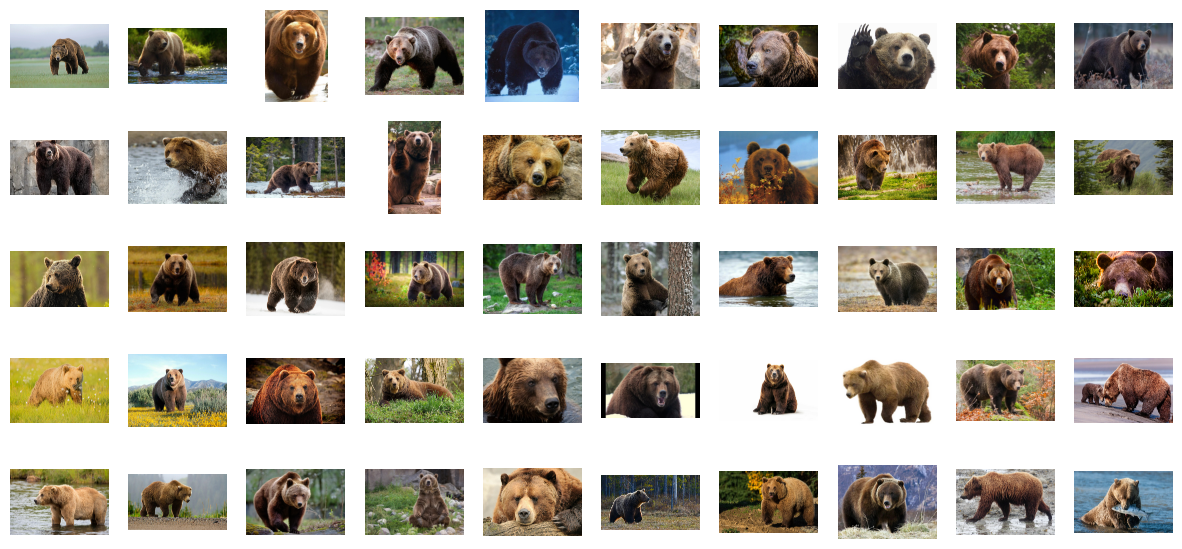

📂 Папка: polar_bear


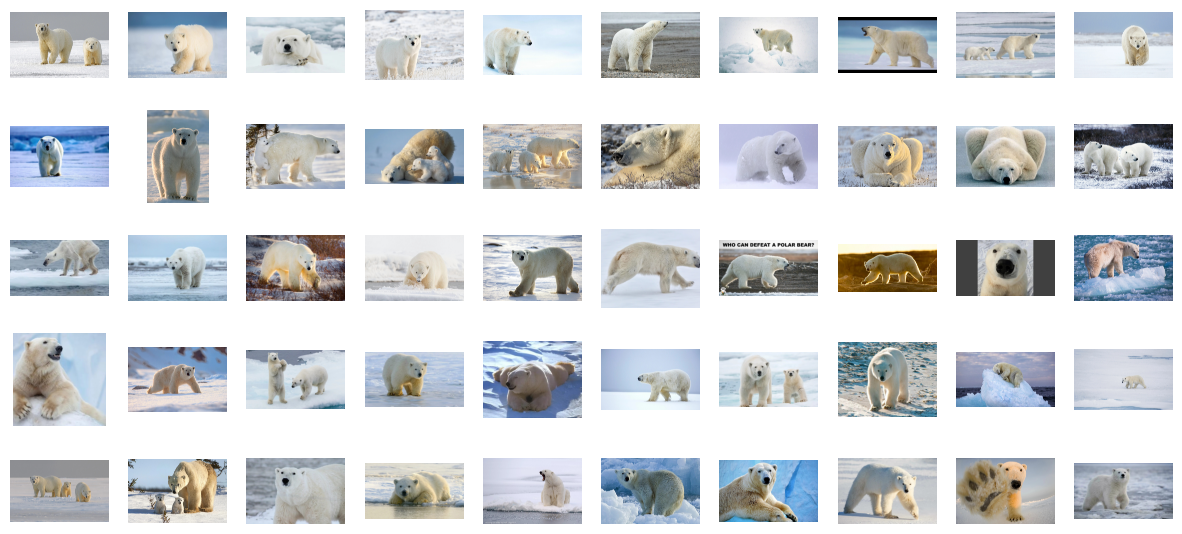

In [7]:


# Основная папка с изображениями
dataset_folder = "dataset"

# Находим все подпапки
subfolders = [os.path.join(SAVE_DIR_FULL, sub) for sub in os.listdir(SAVE_DIR_FULL) if os.path.isdir(os.path.join(SAVE_DIR_FULL, sub))]


for subfolder in subfolders:
    # Собираем изображения в подпапке
    image_files = [os.path.join(subfolder, f) for f in os.listdir(subfolder) if f.endswith((".jpg", ".png", ".jpeg"))]
    
    # Выбираем 50 случайных изображений
    selected_images = random.sample(image_files, min(50, len(image_files)))

    # Отображаем заголовок папки
    print(f"📂 Папка: {os.path.basename(subfolder)}")
    
    # Выводим изображения
    fig, axes = plt.subplots(5, 10, figsize=(15, 7))  
    for ax, img_path in zip(axes.flatten(), selected_images):
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.axis("off")

    plt.show()  
